In [1]:
from telco_llm.chain.performance import create_performance_chain

In [2]:
chain = create_performance_chain()

/home/wau/miniconda3/envs/langchain/lib/python3.11/site-packages/google/cloud/bigquery/client.py:572: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [3]:
#chain.invoke({"messages": "How is the 4G volte call setup performance for site 3707A for last 7 days?"})

In [4]:
#chain.invoke({"messages": "How is the 2G handover success rate performance for site 3707A for last 14 days?"})

In [5]:
#chain.invoke({"messages": "Top 3 worst cell 2G handover success rate performance for site 3707A for last 14 days?"})

In [6]:
#chain.invoke({"messages": "How is the 2G handover success rate and TCH drop rate performance for site 3707A for last 14 days?"})

In [7]:
from langchain_core.prompts import ChatPromptTemplate , MessagesPlaceholder
from telco_llm.tools.chart import plot_timeseries 

def create_agent(llm , tools ):
    
    """Create performance agent"""
    
    prompt  = ChatPromptTemplate.from_messages([
        ("system" , """
            You are telecommunication performance analysis agent that analyse the performance of telecommunication network.
            You required to complete following analysis: 
            1. Is the KPI performance is degraded or improved in general? 
            2. If the KPI performance is degraded in general, please do the drill down analysis on object (from site to cell if available) which top 5 cells are the most poorest performance? 
            3. During the analysis, please plot relevent information in the chart to support your analysis
            
            Please verify you are finish with all the analysis requirement. If all analysis completed, remember to say "FINISH" to end the conversation.
            
            Used the only provided tools to progress towards answering the question. You have access to the following tools: {tool_names}.
            If you are unable to solve problem, that's OK, another assistant with different tools will help were you left off. Just mention what are the task you want to pass to another assistant agent.
        """), 
        MessagesPlaceholder("messages")
    ])
    
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(tools)

In [8]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_openai import ChatOpenAI 
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    AIMessage
)

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    


In [9]:
import functools 

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Agent response result (type:{type(result)}) as follows:")
    print(result)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    elif isinstance(result, str):
        result = AIMessage(content=result , name=name)
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4o-mini")

performance_agent = create_agent(llm , [ plot_timeseries ])
performance_node = functools.partial(agent_node, agent=performance_agent, name="Performance")
query_node = functools.partial(agent_node , agent=chain , name="Query")

In [10]:
from langgraph.prebuilt import ToolNode

tools = [ plot_timeseries ]
tool_node = ToolNode(tools)

In [11]:

# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINISH" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [12]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(AgentState)

workflow.add_node("Performance", performance_node)
workflow.add_node("Query", query_node)
# workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Performance",
    router,
    {"continue": "Query" , "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "Query" , 
    router, 
    {"continue": "Performance"}
)
# workflow.add_conditional_edges(
#     "chart_generator",
#     router,
#     {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
# )

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Performance": "Performance",
        #"chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Performance")
graph = workflow.compile()

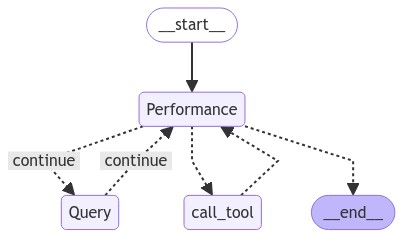

In [13]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Agent response result (type:<class 'langchain_core.messages.ai.AIMessage'>) as follows:
content='To analyze the 4G ERAB drop performance for site 3707A over the last 30 days, I would need the relevant performance data for this specific site. If you can provide the performance values or any datasets, I will be able to plot the timeseries and assess the performance. Please share the data or specify how to access it.' response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 286, 'total_tokens': 358}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0f03d4f0ee', 'finish_reason': 'stop', 'logprobs': None} id='run-56a595f8-e84f-4294-b0b3-adc35567b46a-0' usage_metadata={'input_tokens': 286, 'output_tokens': 72, 'total_tokens': 358}
{'Performance': {'messages': [AIMessage(content='To analyze the 4G ERAB drop performance for site 3707A over the last 30 days, I would need the relevant performance data for this specific site. If you can provide the performance

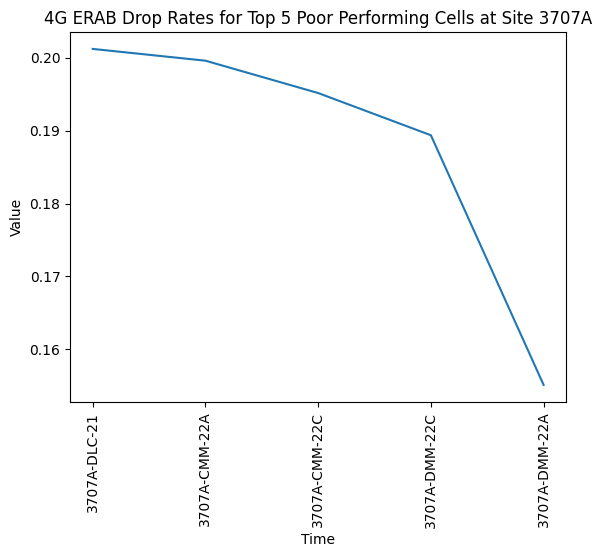

In [14]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="How is the 4G ERAB drop performance for site 3707A for last 30 days?",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")


In [68]:
from langchain_community.agent_toolkits import create_sql_agent  , SQLDatabaseToolkit
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv
from langchain_community.utilities import SQLDatabase
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor , create_tool_calling_agent , create_react_agent
from langchain.agents.format_scratchpad.tools import (
    format_to_tool_messages,
)
from langchain.agents.output_parsers.tools import ToolsAgentOutputParser
from langchain_core.runnables import RunnablePassthrough , RunnableLambda

load_dotenv()

prompt = ChatPromptTemplate.from_messages([
    ("system" , """
    You are a telecommunication performance data agents that can query data from the database. 
    You can query data for a specific date period given a start date and end date. If the period is not provided, you can preceed to setup query for the last 14 days. 

    You need to identify the following information from the question:
    1. Which KPI performance data you want to query? 
    2. Which site / cell you want to query? 

    If you have all the information, you can proceed to query the data, else you can ask for more information. 

    Given the few example as follows for query SQL generation: 
    input : How is the performance 4G Volte Drop Call rate for site 1123A for past 1 weeks
    query : SELECT time , 100*sum(VOLTE_DROP_NUM)/sum(VOLTE_DROP_DENOM) `4G VoLTE Drop Call Rate` FROM `rf-oss.dailydata.mc4g_cell_combined` WHERE Date(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND ( site = '1123A' ) GROUP BY time ORDER BY time

    input : How is the performance 2G TCH Drop rate for site 1123A for past 1 month
    query : SELECT time , 100*sum(TCH_DROP_NUM)/sum(TCH_DROP_DENOM) `2G TCH Drop Rate` FROM `rf-oss.dailydata.mc2g_cell_combined` WHERE Date(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY) AND ( site = '1123A' ) GROUP BY time ORDER BY time

    input : How much total 4G data download traffic for the site 1011A for past 2 week
    query : SELECT sum(LTE_DATA_TRAFFIC_GB) `4G Data Download Traffic` FROM `rf-oss.dailydata.mc4g_cell_combined` WHERE Date(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 14 DAY) AND ( site = '1011A' )

    input : Which cell is having the worst performance 4G RRC setup success rate for 1011A in last 3 days
    query : SELECT object `Cell` , 100*sum(RRC_SETUP_NUM)/sum(RRC_SETUP_DENOM) `RRC Setup Success Rate` FROM `rf-oss.dailydata.mc4g_cell_combined` WHERE Date(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 DAY) AND ( site = '1011A' ) GROUP BY object ORDER BY `RRC Setup Success Rate` LIMIT 1;


    Refer to the following related tables: 
    1. 'mc2g_cell_combined' for 2G performance data
    2. 'mc4g_cell_combined' for 4G performance data
    
    You have access to the following tools: 
    {tool_names}
    
    Tips on flow setup: 
    To start you should ALWAYS look at the tables in the database to see what you can query.
    Do NOT skip this step.
    Then you should query the schema of the most relevant tables.
    Once you have identify the table and relevant columns, you can start to generate the SQL query (in single line only)
    """), 
    ("human" , "{input}"), 
    ("placeholder" , "{agent_scratchpad}")
])

project_id = os.getenv("BIGQUERY_PROJECT_ID")
dataset_id = os.getenv("BIGQUERY_DATASET_ID")
openai_api_key = os.getenv("OPENAI_API_KEY")
service_account_file = os.getenv("GOOGLE_SERVICE_FILE")


# create db
sqlalchemy_url = f'bigquery://{project_id}/{dataset_id}'
db = SQLDatabase.from_uri(sqlalchemy_url , {"credentials_path":service_account_file})
llm = ChatOpenAI(
    model="gpt-4o-mini" ,
    api_key=openai_api_key
)
toolkit = SQLDatabaseToolkit(db=db , llm=llm)

# get tool name and parse to the prompt 
tool_names = [tool.name for tool in toolkit.get_tools()]
prompt = prompt.partial(tool_names=", ".join(tool_names))

tools = toolkit.get_tools()
llm_with_tools = llm.bind_tools(tools)

# agent = create_tool_calling_agent(llm=llm, tools=tools , prompt=prompt) # prompt | llm_with_tools (agent with chain : get_the_intermediate_result as scratchpad result -> system_message -> human_message -> agent_message)
def callback(x):
    print("-------- The intermediate steps are as follows: ---------")
    for step in x["intermediate_steps"]:
        print(step)
    print("_______ end of intermediate steps _______")
    return None

def callback_2(x):
    print("Before format: " , end="")
    print(x)
    return x

def callback_3(x):
    print("After format: " , end="")
    print(x)
    return x

agent = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_to_tool_messages(x["intermediate_steps"]), # the intermediate_step is the list of the tool results from the chain (Create by agent_executor)
        monitor=callback
    )
    | prompt 
    | llm_with_tools 
    | RunnableLambda(callback_2)
    | ToolsAgentOutputParser() # parse the tool result into ToolAgentAction format 
    | RunnableLambda(callback_3)
)

agent_executor = AgentExecutor(agent=agent , tools=tools)


/home/wau/miniconda3/envs/langchain/lib/python3.11/site-packages/google/cloud/bigquery/client.py:572: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [66]:
agent.get_prompts()[0].pretty_print()

================================ System Message ================================


    You are a telecommunication performance data agents that can query data from the database. 
    You can query data for a specific date period given a start date and end date. If the period is not provided, you can preceed to setup query for the last 14 days. 

    You need to identify the following information from the question:
    1. Which KPI performance data you want to query? 
    2. Which site / cell you want to query? 

    If you have all the information, you can proceed to query the data, else you can ask for more information. 

    Given the few example as follows for query SQL generation: 
    input : How is the performance 4G Volte Drop Call rate for site 1123A for past 1 weeks
    query : SELECT time , 100*sum(VOLTE_DROP_NUM)/sum(VOLTE_DROP_DENOM) `4G VoLTE Drop Call Rate` FROM `rf-oss.dailydata.mc4g_cell_combined` WHERE Date(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND ( site =

In [69]:
for event in agent_executor.stream({"input": "How is the 4G ERAB drop performance for site 3707A?"}):
    print(event)
    print("")

-------- The intermediate steps are as follows: ---------
_______ end of intermediate steps _______
Before format: content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_feQuAhzOv4tZF1QsrML3UkFT', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0f03d4f0ee'} id='run-f13f2d3b-fd24-48b6-99e1-fabb894b7bdd' tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_feQuAhzOv4tZF1QsrML3UkFT', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'sql_db_list_tables', 'args': '{}', 'id': 'call_feQuAhzOv4tZF1QsrML3UkFT', 'index': 0, 'type': 'tool_call_chunk'}]
After format: [ToolAgentAction(tool='sql_db_list_tables', tool_input={}, log='\nInvoking: `sql_db_list_tables` with `{}`\n\n\n', message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_feQuAhzOv4tZF1QsrML3UkFT', 'function': {'a